# transform

> transform coordinate between projection

In [ ]:
#| default_exp cli/utils/transform

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from decorrelation.cli.utils.logging import get_logger

In [ ]:
#| export
import multiprocessing
import concurrent
import numpy as np
import zarr
import logging
from pyproj import Transformer

from decorrelation.cli.utils.logging import de_logger, log_args
from fastcore.script import call_parse

In [ ]:
#| export
def transform(xx_in, # input x coordinate
              yy_in, # input y coordinate
              epsg_in=4326, # input epsg
              epsg_out=3857, # output epsg
              n_worker=None, # number of worker, all cpus by default
             ):
    if n_worker is None: n_worker = multiprocessing.cpu_count()
    transformer = Transformer.from_crs(f"EPSG:{epsg_in}", f"EPSG:{epsg_out}",always_xy=True)
    # xx_out = np.empty_like(xx_in); yy_out = np.empty_like(yy_in)
    # xx_out_split = np.array_split(xx_out,n_worker); yy_out_split = np.array_split(yy_out,n_worker)
    xx_out_list = []; yy_out_list = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_worker) as executor:
        for i, (_xx_out, _yy_out) in enumerate(executor.map(transformer.transform,np.array_split(xx_in,n_worker),np.array_split(yy_in,n_worker))):
            xx_out_list.append(_xx_out); yy_out_list.append(_yy_out)
    return np.concatenate(xx_out_list), np.concatenate(yy_out_list)

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_transform(xx_in, # input x coordinate
                 yy_in, # input y coordinate
                 xx_out, # output x coordinate
                 yy_out, # output y coordinate
                 epsg_in=4326, # input epsg
                 epsg_out=3857, # output epsg
                ):
    '''Coordinate transformation.
    By default, the input should be longitude (xx_in) and latitude (yy_in) (in degree) and outputs 
    are x (east) and y (south) coordinate in web mercator projection (for plot with google earth map).
    The chunks, shape and dtype of output are same as `xx_in`.
    '''
    logger = logging.getLogger(__name__)
    xx_in_path = xx_in; yy_in_path = yy_in; xx_out_path = xx_out; yy_out_path = yy_out

    logger.info(f'input EPSG: {epsg_in}.')
    xx_in_zarr = zarr.open(xx_in_path,'r'); yy_in_zarr = zarr.open(yy_in_path,'r')
    logger.zarr_info('xx_in',xx_in_zarr); logger.zarr_info('yy_in',yy_in_zarr)
    logger.info(f'output EPSG: {epsg_out}.')
    logger.info(f'do the transformation.')
    xx_out, yy_out = transform(xx_in_zarr[:],yy_in_zarr[:])
    logger.info(f'write output.')
    xx_out_zarr = zarr.open(xx_out_path,'w',shape=xx_in_zarr.shape,dtype=xx_in_zarr.dtype,chunks=xx_in_zarr.chunks)
    yy_out_zarr = zarr.open(yy_out_path,'w',shape=xx_in_zarr.shape,dtype=xx_in_zarr.dtype,chunks=xx_in_zarr.chunks)
    xx_out_zarr[:] = xx_out; yy_out_zarr[:] = yy_out
    logger.info(f'write done.')

Usage:

In [ ]:
lon_ = './transform/lon.zarr/'; lat_ = './transform/lat.zarr/'
e_ = './transform/e.zarr'; n_ = './transform/n.zarr'
logger = get_logger()

In [ ]:
de_transform(lon_,lat_,e_,n_)

2023-11-05 23:31:51 - logging_args - INFO - running function: de_transform
2023-11-05 23:31:51 - logging_args - INFO - fetching args:
2023-11-05 23:31:51 - logging_args - INFO - xx_in = './transform/lon.zarr/'
2023-11-05 23:31:51 - logging_args - INFO - yy_in = './transform/lat.zarr/'
2023-11-05 23:31:51 - logging_args - INFO - xx_out = './transform/e.zarr'
2023-11-05 23:31:51 - logging_args - INFO - yy_out = './transform/n.zarr'
2023-11-05 23:31:51 - logging_args - INFO - epsg_in = 4326
2023-11-05 23:31:51 - logging_args - INFO - epsg_out = 3857
2023-11-05 23:31:51 - logging_args - INFO - fetching args done.
2023-11-05 23:31:51 - de_transform - INFO - input EPSG: 4326.
2023-11-05 23:31:51 - zarr_info - INFO - xx_in zarray shape: (2500, 1834)
2023-11-05 23:31:51 - zarr_info - INFO - xx_in zarray chunks: (1000, 1834)
2023-11-05 23:31:51 - zarr_info - INFO - xx_in zarray dtype: float64
2023-11-05 23:31:51 - zarr_info - INFO - yy_in zarray shape: (2500, 1834)
2023-11-05 23:31:51 - zarr_in

In [ ]:
lon = zarr.open(lon_,mode='r')[:]
lat = zarr.open(lat_,mode='r')[:]
lon[lon==0] = np.nan
lat[lat==0] = np.nan

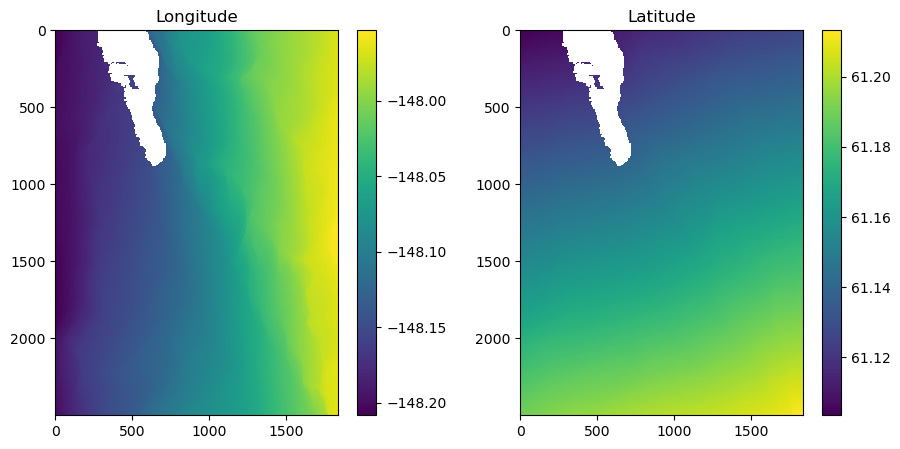

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(11,5))
im0 = axes[0].imshow(lon)
axes[0].set_title('Longitude')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(lat)
axes[1].set_title('Latitude')
fig.colorbar(im1, ax=axes[1])
fig.show()

In [ ]:
e = zarr.open(e_,mode='r')[:]
n = zarr.open(n_,mode='r')[:]
e[e==0] = np.nan
n[n==0] = np.nan

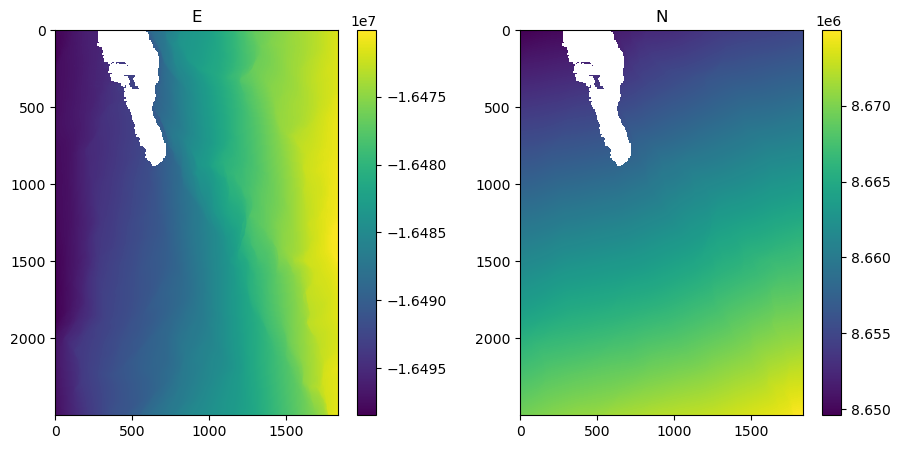

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(11,5))
im0 = axes[0].imshow(e)
axes[0].set_title('E')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(n)
axes[1].set_title('N')
fig.colorbar(im1, ax=axes[1])
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()